In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!tar -zxvf "/content/drive/MyDrive/python_Training/OpenCV/annotations.tar.gz"
!tar -zxvf "/content/drive/MyDrive/python_Training/OpenCV/images.tar.gz"

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
images/american_bulldog_194.jpg
images/Birman_175.jpg
images/american_bulldog_178.jpg
images/staffordshire_bull_terrier_93.jpg
images/Egyptian_Mau_58.jpg
images/havanese_44.jpg
images/english_cocker_spaniel_97.jpg
images/Ragdoll_111.jpg
images/american_pit_bull_terrier_159.jpg
images/english_setter_134.jpg
images/english_setter_87.jpg
images/wheaten_terrier_198.jpg
images/pug_180.jpg
images/boxer_172.jpg
images/Sphynx_197.jpg
images/german_shorthaired_2.jpg
images/British_Shorthair_9.jpg
images/pug_89.jpg
images/japanese_chin_39.jpg
images/Ragdoll_20.jpg
images/american_bulldog_111.jpg
images/yorkshire_terrier_112.jpg
images/Persian_88.jpg
images/pug_9.jpg
images/Birman_40.jpg
images/British_Shorthair_272.jpg
images/havanese_7.jpg
images/pomeranian_154.jpg
images/beagle_49.jpg
images/British_Shorthair_94.jpg
images/Persian_90.jpg
images/staffordshire_bull_terrier_30.jpg
images/samoyed_113.jpg
images/english_cocker_spaniel_46.jpg
images/Abyssinian_22.

In [3]:
from keras.utils import Sequence
from keras.models import Model
from keras.layers import Input,Activation,Conv2D,BatchNormalization,SeparableConv2D,MaxPooling2D,UpSampling2D,Conv2DTranspose,add
import os
from keras.preprocessing.image import load_img
import numpy as np
import random

input_dir='./images/'
target_dir='./annotations/trimaps/'
img_size=(160,160)
n_calss=3 #분할 레이블(1:물체,2:배경,3:경계)
batch_size=32

img_paths=sorted([os.path.join(input_dir,f)
                  for f in os.listdir(input_dir)
                  if f.endswith('.jpg')])
label_paths=sorted([os.path.join(target_dir,f)
                    for f in os.listdir(target_dir)
                    if f.endswith('.png') and not f.startswith('.')])

class N_m_data(Sequence):
    def __init__(self,batch_size,img_size,img_paths,label_paths):
        self.batch_size=batch_size
        self.img_size=img_size
        self.img_paths=img_paths
        self.label_paths=label_paths

    def __len__(self):
        return len(self.label_paths)//self.batch_size

    def __getitem__(self, index):
        idx=index*self.batch_size
        batch_img_paths=self.img_paths[idx:idx+self.batch_size]
        batch_label_paths=self.label_paths[idx:idx+self.batch_size]
        x=np.zeros((self.batch_size,)+self.img_size+(3,),'float32')
        for i,path in enumerate(batch_img_paths):
            img = load_img(path,target_size=self.img_size)
            x[i] = img
        y=np.zeros((self.batch_size,)+self.img_size+(1,),'uint8')
        for i,path in enumerate(batch_label_paths):
            img = load_img(path,target_size=self.img_size,color_mode='grayscale')
            y[i] = np.expand_dims(img,2)
            y[i]-=1 #부류번호 1,2,3 -> 0,1,2
        return x,y

def mk_model(img_size,n_class):
    inputs=Input(shape=img_size+(3,))

    #U_net 다운샘플링(축소 경로)
    x=Conv2D(32,3,strides=2,padding='same')(inputs)
    x=BatchNormalization()(x)
    x=Activation("relu")(x)
    pre_block_act=x #(지름길 경로 연결을 위한 값)

    for filt in [64,128,256]:
        x=Activation('relu')(x)
        x=SeparableConv2D(filt,3,padding='same')(x)
        x=BatchNormalization()(x)
        x=Activation('relu')(x)
        x=SeparableConv2D(filt,3,padding='same')(x)
        x=BatchNormalization()(x)
        x=MaxPooling2D(3,strides=2,padding='same')(x)
        residual=Conv2D(filt,1,strides=2,padding='same')(pre_block_act)
        x=add([x,residual])#지름길 연결
        pre_block_act = x#(지름길 경로 연결을 위한 값)

    #U_net 업샘플링(확대 경로)
    for filt in [256,128,64,32]:
        x=Activation('relu')(x)
        x=Conv2DTranspose(filt,3,padding='same')(x)
        x=BatchNormalization()(x)
        x=Activation('relu')(x)
        x=Conv2DTranspose(filt,3,padding='same')(x)
        x=BatchNormalization()(x)
        x=UpSampling2D(2)(x)
        residual=UpSampling2D(2)(pre_block_act)
        residual=Conv2D(filt,1,padding='same')(residual)
        x=add([x,residual])#지름길 연결
        pre_block_act = x

    outputs=Conv2D(n_class,3,activation="softmax",padding="same")(x)
    m = Model(inputs,outputs)
    return m

random.Random(1).shuffle(img_paths)
random.Random(1).shuffle(label_paths)
tt_samp=int(len(img_paths)*0.1)#10%태스트 데이터
tr_img_paths=img_paths[:-tt_samp]
tr_label_paths=label_paths[:-tt_samp]
tt_img_paths=img_paths[-tt_samp:]
tt_label_paths=label_paths[-tt_samp:]

tr_dataset=N_m_data(batch_size,img_size,tr_img_paths,tr_label_paths)
tt_dataset=N_m_data(batch_size,img_size,tt_img_paths,tt_label_paths)


In [4]:
m=mk_model(img_size,n_calss)

m.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics='acc')
from keras.callbacks import ModelCheckpoint
cb=[ModelCheckpoint("u_net_m.h5",save_best_only=True)]
m.fit(tr_dataset,epochs=30,validation_data=tt_dataset,callbacks=cb)

Epoch 1/30
 74/207 [=========>....................] - ETA: 19:00 - loss: 1.2170 - acc: 0.3202

KeyboardInterrupt: ignored

Epoch 1/30
207/207 [==============================] - ETA: 0s - loss: 0.7866 - acc: 0.3180

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 3s 3s/step


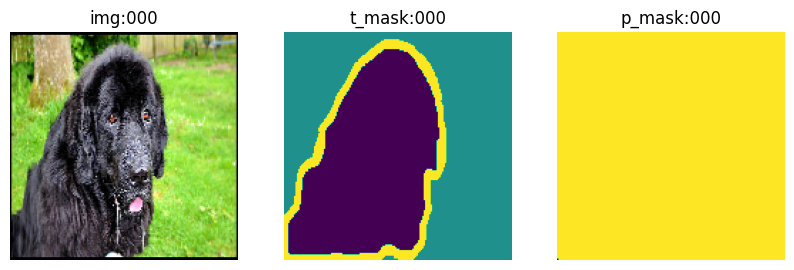

207/207 [==============================] - 1883s 9s/step - loss: 0.7866 - acc: 0.3180 - val_loss: 3.3848 - val_acc: 3.7417e-05
Epoch 2/30
207/207 [==============================] - 1834s 9s/step - loss: 0.5040 - acc: 0.3141 - val_loss: 2.6568 - val_acc: 0.0000e+00
Epoch 3/30
207/207 [==============================] - 1828s 9s/step - loss: 0.4426 - acc: 0.3137 - val_loss: 0.5367 - val_acc: 0.2243
Epoch 4/30
1/1 [==============================] - 3s 3s/step


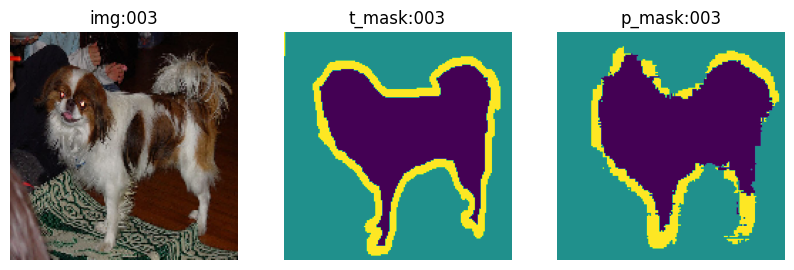

207/207 [==============================] - 1807s 9s/step - loss: 0.3986 - acc: 0.3131 - val_loss: 0.4514 - val_acc: 0.2479
Epoch 5/30
207/207 [==============================] - 1829s 9s/step - loss: 0.3712 - acc: 0.3118 - val_loss: 0.4002 - val_acc: 0.2962
Epoch 6/30
207/207 [==============================] - 1825s 9s/step - loss: 0.3482 - acc: 0.3114 - val_loss: 0.4136 - val_acc: 0.3376
Epoch 7/30
1/1 [==============================] - 2s 2s/step


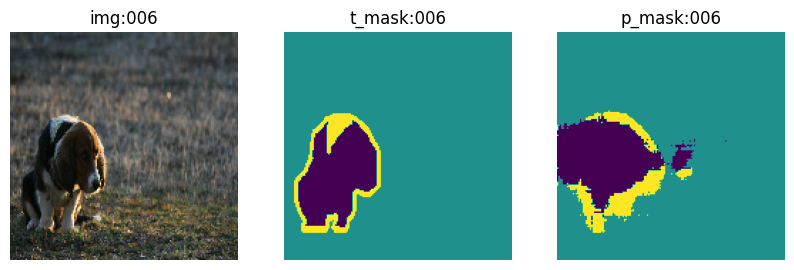

207/207 [==============================] - 1812s 9s/step - loss: 0.3196 - acc: 0.3104 - val_loss: 0.3941 - val_acc: 0.3292
Epoch 8/30
207/207 [==============================] - 1794s 9s/step - loss: 0.2978 - acc: 0.3106 - val_loss: 0.3996 - val_acc: 0.3467
Epoch 9/30
207/207 [==============================] - 1771s 9s/step - loss: 0.2778 - acc: 0.3097 - val_loss: 0.4454 - val_acc: 0.2493
Epoch 10/30
1/1 [==============================] - 3s 3s/step


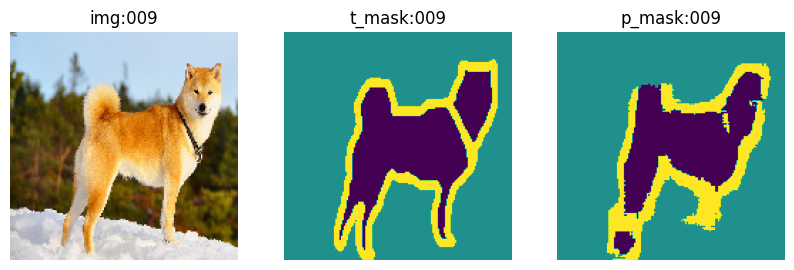

207/207 [==============================] - 1808s 9s/step - loss: 0.2599 - acc: 0.3089 - val_loss: 0.3909 - val_acc: 0.3038
Epoch 11/30
207/207 [==============================] - 1771s 9s/step - loss: 0.2462 - acc: 0.3083 - val_loss: 0.3845 - val_acc: 0.2933
Epoch 12/30
149/207 [====================>.........] - ETA: 7:54 - loss: 0.2202 - acc: 0.3088

In [ ]:
from keras.utils import Sequence
from keras.models import Model
from keras.layers import Input,Activation,Conv2D,BatchNormalization,SeparableConv2D,MaxPooling2D,UpSampling2D,Conv2DTranspose,add
import os
from keras.preprocessing.image import load_img
import numpy as np
import random

input_dir='./images/'
target_dir='./annotations/trimaps/'
img_size=(160,160)
n_calss=3 #분할 레이블(1:물체,2:배경,3:경계)
batch_size=32

img_paths=sorted([os.path.join(input_dir,f)
                  for f in os.listdir(input_dir)
                  if f.endswith('.jpg')])
label_paths=sorted([os.path.join(target_dir,f)
                    for f in os.listdir(target_dir)
                    if f.endswith('.png') and not f.startswith('.')])

class N_m_data(Sequence):
    def __init__(self,batch_size,img_size,img_paths,label_paths):
        self.batch_size=batch_size
        self.img_size=img_size
        self.img_paths=img_paths
        self.label_paths=label_paths

    def __len__(self):
        return len(self.label_paths)//self.batch_size

    def __getitem__(self, index):
        idx=index*self.batch_size
        batch_img_paths=self.img_paths[idx:idx+self.batch_size]
        batch_label_paths=self.label_paths[idx:idx+self.batch_size]
        x=np.zeros((self.batch_size,)+self.img_size+(3,),'float32')
        for i,path in enumerate(batch_img_paths):
            img = load_img(path,target_size=self.img_size)
            x[i] = img
        y=np.zeros((self.batch_size,)+self.img_size+(1,),'uint8')
        for i,path in enumerate(batch_label_paths):
            img = load_img(path,target_size=self.img_size,color_mode='grayscale')
            y[i] = np.expand_dims(img,2)
            y[i]-=1 #부류번호 1,2,3 -> 0,1,2
        return x,y

def mk_model(img_size,n_class):
    inputs=Input(shape=img_size+(3,))

    #U_net 다운샘플링(축소 경로)
    x=Conv2D(32,3,strides=2,padding='same')(inputs)
    x=BatchNormalization()(x)
    x=Activation("relu")(x)
    pre_block_act=x #(지름길 경로 연결을 위한 값)

    for filt in [64,128,256]:
        x=Activation('relu')(x)
        x=SeparableConv2D(filt,3,padding='same')(x)
        x=BatchNormalization()(x)
        x=Activation('relu')(x)
        x=SeparableConv2D(filt,3,padding='same')(x)
        x=BatchNormalization()(x)
        x=MaxPooling2D(3,strides=2,padding='same')(x)
        residual=Conv2D(filt,1,strides=2,padding='same')(pre_block_act)
        x=add([x,residual])#지름길 연결
        pre_block_act = x#(지름길 경로 연결을 위한 값)

    #U_net 업샘플링(확대 경로)
    for filt in [256,128,64,32]:
        x=Activation('relu')(x)
        x=Conv2DTranspose(filt,3,padding='same')(x)
        x=BatchNormalization()(x)
        x=Activation('relu')(x)
        x=Conv2DTranspose(filt,3,padding='same')(x)
        x=BatchNormalization()(x)
        x=UpSampling2D(2)(x)
        residual=UpSampling2D(2)(pre_block_act)
        residual=Conv2D(filt,1,padding='same')(residual)
        x=add([x,residual])#지름길 연결
        pre_block_act = x

    outputs=Conv2D(n_class,3,activation="softmax",padding="same")(x)
    m = Model(inputs,outputs)
    return m

random.Random(1).shuffle(img_paths)
random.Random(1).shuffle(label_paths)
tt_samp=int(len(img_paths)*0.1)#10%태스트 데이터
tr_img_paths=img_paths[:-tt_samp]
tr_label_paths=label_paths[:-tt_samp]
tt_img_paths=img_paths[-tt_samp:]
tt_label_paths=label_paths[-tt_samp:]

tr_dataset=N_m_data(batch_size,img_size,tr_img_paths,tr_label_paths)
tt_dataset=N_m_data(batch_size,img_size,tt_img_paths,tt_label_paths)

from keras.callbacks import Callback
import tensorflow as tf
import matplotlib.pyplot as plt

class DisplayCallback(Callback):
    def __init__(self, ep_n = None, ck_dataset = None, batch_size = None):
        self.ep_n = ep_n
        self.test_imgs, self.test_masks = next(iter(ck_dataset))
        self.batch_size = batch_size

    def on_epoch_end(self, epoch, logs = None):
        if self.ep_n and epoch % self.ep_n == 0:
            pre_masks = self.model.predict(self.test_imgs)
            pre_masks = tf.math.argmax(pre_masks, axis = -1)
            pre_masks = pre_masks[..., tf.newaxis]

            r_idx = random.randint(0, self.batch_size - 1)
            r_img = self.test_imgs[r_idx]
            r_t_mask = self.test_masks[r_idx]
            r_p_mask = pre_masks[r_idx]

            fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (10, 5))
            ax[0].imshow(r_img.astype('uint8'))
            ax[0].axis('off')
            ax[0].set_title(f"img:{epoch:03d}")

            ax[1].imshow(r_t_mask)
            ax[1].axis('off')
            ax[1].set_title(f"t_mask:{epoch:03d}")

            ax[2].imshow(r_p_mask)
            ax[2].axis('off')
            ax[2].set_title(f"p_mask:{epoch:03d}")

            plt.show()
            plt.close()




m=mk_model(img_size,n_calss)

m.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics='acc')
from keras.callbacks import ModelCheckpoint
cb=[ModelCheckpoint("u_net_m.h5",save_best_only=True), DisplayCallback(3, tt_dataset, batch_size)]
m.fit(tr_dataset,epochs=30,validation_data=tt_dataset,callbacks=cb)